<img src='./img/header_placeholder.png' alt='Logo EU Copernicus ECMWF' align='right' width='100%'></img>

# CAMS Dust monitoring

### About

This notebook provides you a practical introduction to the [CAMS European air quality forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-europe-air-quality-forecasts?tab=overview) and [CAMS global atmospheric composition forecasts](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-atmospheric-composition-forecasts?tab=overview) data sets. We will use both datasets to analyse a Saharan dust event that impacted Europe (primarily parts of Spain and France) between 21 to 23 February 2021. 

The notebook has three main sections with the following outline:

* [1 - Define a discrete, not continuous color scale used in CAMS](#cams_colormap)
* [2 - CAMS European air quality forecasts](#europe_aq_forecast)
  * [2.1 - Load and browse CAMS European air quality forecasts](#eur_aq_load_browse)
  * [2.2 - Select the variable *dust* and plot a map of dust over Europe in February 2021](#dust_map)
  * [2.3 - Select the variable *pm10_conc* and plot a map of PM10 over Europe in February 2021](#pm10_map)
  * [2.4 - Animate dust concentration over Europe from 20-25 February 2021](animate_dust_regional)
* [3 - CAMS global atmospheric composition forecasts](#global_aq_forecast)
  * [3.1 - Unzip the downloaded data file](#cams_forecast_unzip)
  * [3.2 - Load and browse CAMS global forecast of total Aerosol Optical Depth at 550nm](#load_browse_aod)
  * [3.3 - Visualize a global map of total AOD at 550nm in February 2021](#visualize_global_aod)
  * [3.4 - Animate global total AOD at 550nm from 20 to 23 February 2021](#animate_dust_global)

### Data

This notebook introduces you to the `CAMS European air quality forecasts` and the `CAMS global atmospheric composition forecasts`. The data has the following specifications:

> **Data**: `CAMS European air quality forecasts` <br>
> **Variables**: `Dust`, `Particulate Matter 10` <br>
> **Type**: `Analysis` <br>
> **Temporal coverage**: `20-25 February 2021` <br>
> **Temporal resolution**: `hourly` <br>
> **Spatial coverage**: `Europe` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./200_atmosphere_data_store_intro.ipynb#europe_air_quality)

<br>

> **Data**: `CAMS global atmospheric composition forecasts` <br>
> **Variables**: `Total Aerosol Optical Depth 550` <br>
> **Type**: `Forecast` <br>
> **Temporal coverage**: `20 February 2021` <br>
> **Leadtime hour**: `0 to 90` <br>
> **Spatial coverage**: `Global` <br>
> **Format**: `NetCDF`<br>
> **Retrieve request**: [CDS API request](./100_climate_data_store_intro.ipynb#era5_monthly)

Get [here](./201_cams_data_intro.ipynb) more information about CAMS data in general including an overview of the different dataset types.

### How to access the notebook
* via [nbviewer](https://github.com/ecmwf-projects/copernicus-training/blob/master/111_c3s_climatologies_anomalies.ipynb): view a static version of the notebook 
* via [Binder](https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training/HEAD?urlpath=lab/tree/111_c3s_climatologies_anomalies.ipynb): run, execute and modify the notebook

### Further resources

* [Saharan dust events in the spring of 2021 | ECMWF Newsletter Number 168](https://www.ecmwf.int/en/newsletter/168/news/saharan-dust-events-spring-2021)

<hr>

### Load libraries

In [1]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import HTML

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import animation

from datetime import datetime

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

### Load helper function

In [9]:
%run ./functions.ipynb

<hr>

## <a id='cams_colormap'></a>1. Define a discrete, not continuous color scale used in CAMS

CAMS uses a `customized discrete, not continuous color scale` for many of their atmospheric composition charts. In this example, we want to represent the data in the CAMS style and for this, we want to define a customised color map.

The color scale consists of 14 colors, which are defined as red, green and blue color codes. As a first step, you can create a numpy array with 14 rows and 3 columns, where the color code for each color is stored. Each of the 14 colors in the color map will be multiplied by n (n=18) to create a final color map of `14*18+1=253` listed colors. The addition of 1 is to create a starting color of white.

The next step is then to create an empty numpy array (`cams`) with the shape of 253 rows and 4 columns. In a loop, which goes through each of the 14 colour codes defined in the matrix array and divides the RGB values with 256. In a final step, we create an a `ListedColormap()` object, which we can use with matplotlib plotting functions.

In [2]:
matrix = np.array([[210, 214, 234],
                   [167, 174, 214],
                   [135, 145, 190],
                   [162, 167, 144],
                   [189, 188, 101],
                   [215, 209, 57],
                   [242, 230, 11],
                   [243, 197, 10],
                   [245, 164, 8],
                   [247, 131, 6],
                   [248, 98, 5],
                   [250, 65, 3],
                   [252, 32, 1],
                   [254, 0, 0]])


# Multiplication number
n = 18

# 'cams' is an initial empty colourmap, to be filled by the colours provided in 'matrix'.
cams = np.ones((253, 4))

# This loop fills in the empty 'cams' colourmap with each of the 14 colours in 'matrix'
# multiplied by 'n', with the first row left as 1 (white). Note that each colour value is 
# divided by 256 to normalise the colour range from 0 (black) to 1 (white). 
for i in range(matrix.shape[0]):
    cams[((i*n)+1):(((i+1)*n)+1),:] = np.array([matrix[i,0]/256, matrix[i,1]/256, matrix[i,2]/256, 1])

# The final color map is given by 'camscmp', which uses the Matplotlib class 'ListedColormap(Colormap)'
# to generate a colourmap object from the list of colours provided by 'cams'.
camscmp = ListedColormap(cams)

<br>

## <a id='europe_aq_forecast'></a>2. CAMS European air quality forecasts

First, let us discover the CAMS European air quality forecasts which produces daily air quality analyses and forecasts for the European domain at a spatial resolution of 0.1 degrees, approx. 10 km).

### <a id='eur_aq_load_browse'></a> 2.1 Load and browse CAMS European air quality forecasts


The European air quality forecasts data are available either in `GRIB` or in `NetCDF` format. We requested the forecast of dust and Particulate Matter of 10 microns for 20 February 2021 in `NetCDF` format (see [data request](./200_atmosphere_data_store_intro.ipynb#europe_air_quality)). You can use the Python library [xarray](http://xarray.pydata.org/en/stable/) and the function `open_dataset()` to load a NetCDF file as `xarray.Dataset`. A xarray Dataset is a collection of one or more variables that share the same dimensions. Below, you see that the Dataset has four dimensions, `latitude`, `level`, `longitude` and `time`, and two variables, `dust` and `pm10_conc`.

In [13]:
ds_eur_aq = xr.open_dataset('./data/cams/20210220-25_eur_aq_analysis_dust_pm10.nc')
ds_eur_aq

<xarray.Dataset>
Dimensions:    (latitude: 420, level: 1, longitude: 700, time: 144)
Coordinates:
  * longitude  (longitude) float32 335.0 335.1 335.2 335.4 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) timedelta64[ns] 00:00:00 01:00:00 ... 5 days 23:00:00
Data variables:
    dust       (time, level, latitude, longitude) float32 ...
    pm10_conc  (time, level, latitude, longitude) float32 ...
Attributes:
    title:        Dust/PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210220-20210225+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of Dust/PM10 concentration a...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

Let us inspect the coordinates of the file more in detail. You see above that the data set consists of 144 time steps, starting on 20 February 2021 00 UTC and ranging up to 5 days ahead and that the longitude values are on a [0, 360] grid. 

However, if you inspect time dimension more in detail, you see that the time is given in nanoseconds. As a next step, let us convert the time information into a human-readable time format and bring the longitude coordinates to a [-180, 180] grid.

In [14]:
ds_eur_aq.time

<xarray.DataArray 'time' (time: 144)>
array([              0,   3600000000000,   7200000000000,  10800000000000,
        14400000000000,  18000000000000,  21600000000000,  25200000000000,
        28800000000000,  32400000000000,  36000000000000,  39600000000000,
        43200000000000,  46800000000000,  50400000000000,  54000000000000,
        57600000000000,  61200000000000,  64800000000000,  68400000000000,
        72000000000000,  75600000000000,  79200000000000,  82800000000000,
        86400000000000,  90000000000000,  93600000000000,  97200000000000,
       100800000000000, 104400000000000, 108000000000000, 111600000000000,
       115200000000000, 118800000000000, 122400000000000, 126000000000000,
       129600000000000, 133200000000000, 136800000000000, 140400000000000,
       144000000000000, 147600000000000, 151200000000000, 154800000000000,
       158400000000000, 162000000000000, 165600000000000, 169200000000000,
       172800000000000, 176400000000000, 180000000000000, 183600000000000,
       187200000000000, 190800000000000, 194400000000000, 198000000000000,
       201600000000000, 205200000000000, 208800000000000, 212400000000000,
       216000000000000, 219600000000000, 223200000000000, 226800000000000,
       230400000000000, 234000000000000, 237600000000000, 241200000000000,
       244800000000000, 248400000000000, 252000000000000, 255600000000000,
       259200000000000, 262800000000000, 266400000000000, 270000000000000,
       273600000000000, 277200000000000, 280800000000000, 284400000000000,
       288000000000000, 291600000000000, 295200000000000, 298800000000000,
       302400000000000, 306000000000000, 309600000000000, 313200000000000,
       316800000000000, 320400000000000, 324000000000000, 327600000000000,
       331200000000000, 334800000000000, 338400000000000, 342000000000000,
       345600000000000, 349200000000000, 352800000000000, 356400000000000,
       360000000000000, 363600000000000, 367200000000000, 370800000000000,
       374400000000000, 378000000000000, 381600000000000, 385200000000000,
       388800000000000, 392400000000000, 396000000000000, 399600000000000,
       403200000000000, 406800000000000, 410400000000000, 414000000000000,
       417600000000000, 421200000000000, 424800000000000, 428400000000000,
       432000000000000, 435600000000000, 439200000000000, 442800000000000,
       446400000000000, 450000000000000, 453600000000000, 457200000000000,
       460800000000000, 464400000000000, 468000000000000, 471600000000000,
       475200000000000, 478800000000000, 482400000000000, 486000000000000,
       489600000000000, 493200000000000, 496800000000000, 500400000000000,
       504000000000000, 507600000000000, 511200000000000, 514800000000000],
      dtype='timedelta64[ns]')
Coordinates:
  * time     (time) timedelta64[ns] 00:00:00 01:00:00 ... 5 days 23:00:00
Attributes:
    long_name:  ANALYSIS time from 20210220

First, from the `long_name` information of the time dimension, we can retrieve the initial timestamp. With the function `strptime()` from Python's `datetime` library, we can convert it into a `datetime.datetime` object.

In [15]:
timestamp = ds_eur_aq.time.long_name[19:27]

timestamp_init=datetime.strptime(timestamp,'%Y%m%d' )
timestamp_init

datetime.datetime(2021, 2, 20, 0, 0)

In a next step, we then build a `DateTimeIndex` object with the help of Panda's `date_range()` function, making use of the length of the time dimension. The result is a `DateTimeIndex` object, which can be used to newly assign the time coordinate information.

In [16]:
time_coords = pd.date_range(timestamp_init, periods=len(ds_eur_aq.time), freq='1h').strftime("%Y-%m-%d %H:%M:%S").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2021-02-20 00:00:00', '2021-02-20 01:00:00',
               '2021-02-20 02:00:00', '2021-02-20 03:00:00',
               '2021-02-20 04:00:00', '2021-02-20 05:00:00',
               '2021-02-20 06:00:00', '2021-02-20 07:00:00',
               '2021-02-20 08:00:00', '2021-02-20 09:00:00',
               ...
               '2021-02-25 14:00:00', '2021-02-25 15:00:00',
               '2021-02-25 16:00:00', '2021-02-25 17:00:00',
               '2021-02-25 18:00:00', '2021-02-25 19:00:00',
               '2021-02-25 20:00:00', '2021-02-25 21:00:00',
               '2021-02-25 22:00:00', '2021-02-25 23:00:00'],
              dtype='datetime64[ns]', length=144, freq=None)

<br>

And the last step is to assign the converted time information to the DataArray `dust`, with the function `assign_coords()`.

In [17]:
ds_eur_aq = ds_eur_aq.assign_coords(time=time_coords)
ds_eur_aq

<xarray.Dataset>
Dimensions:    (latitude: 420, level: 1, longitude: 700, time: 144)
Coordinates:
  * longitude  (longitude) float32 335.0 335.1 335.2 335.4 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2021-02-20 ... 2021-02-25T23:00:00
Data variables:
    dust       (time, level, latitude, longitude) float32 ...
    pm10_conc  (time, level, latitude, longitude) float32 ...
Attributes:
    title:        Dust/PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210220-20210225+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of Dust/PM10 concentration a...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

As a final step, we now also want to re-assign the longitude values and shift the grid from [0,360] to [-180,180]. At the end, you might want to sort the longitude values in an ascending order.

In [18]:
ds_eur_aq = ds_eur_aq.assign_coords(longitude=(((ds_eur_aq.longitude + 180) % 360) - 180)).sortby('longitude')
ds_eur_aq

<xarray.Dataset>
Dimensions:    (latitude: 420, level: 1, longitude: 700, time: 144)
Coordinates:
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * level      (level) float32 0.0
  * time       (time) datetime64[ns] 2021-02-20 ... 2021-02-25T23:00:00
Data variables:
    dust       (time, level, latitude, longitude) float32 ...
    pm10_conc  (time, level, latitude, longitude) float32 ...
Attributes:
    title:        Dust/PM10 Air Pollutant ANALYSIS at the Surface
    institution:  Data produced by Meteo France
    source:       Data from ENSEMBLE model
    history:      Model ENSEMBLE ANALYSIS
    ANALYSIS:     Europe, 20210220-20210225+[0H_23H]
    summary:      ENSEMBLE model hourly ANALYSIS of Dust/PM10 concentration a...
    project:      MACC-RAQ (http://macc-raq.gmes-atmosphere.eu)

<br>

### <a id='dust_map'></a> 2.2 Select the variable *dust* and plot a map of dust over Europe in February 2021


As a next step, we want to select the variable `dust` from the Dataset above. You can select a variable from a Dataset by adding the name of the variable in square brackets. By selecting a variable, you load the variable as xarray.DataArray, which provides additional attribute information about the data, such as `units` or `standard_name`. For the variable `dust`, you see that the unit of the data is `µg/m3` and it reflects the `mass concentration of dust in air`.

Since the dimension `level` has only one entry reflecting the surface, we can apply the function `squeeze()`, which drops all coordinates with only one entry.

In [19]:
dust = ds_eur_aq['dust']
dust = dust.squeeze(drop=True)
dust

<xarray.DataArray 'dust' (time: 144, latitude: 420, longitude: 700)>
[42336000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * time       (time) datetime64[ns] 2021-02-20 ... 2021-02-25T23:00:00
Attributes:
    species:        Dust
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_dust_in_air

Let us store the attributes `units` and `species` as variables, which we can use later when visualising the data.

In [20]:
dust_unit = dust.units
dust_name = dust.species

<br>

Now we can plot the data with the customised color map (`camscmp`) we have created at the beginning. The visualisation code beow can be split in five main parts:
* **Initiate a matplotlib figure:** with `plt.figure()` and an axes object
* **Plotting function**: plot the data array with the matplotlib function `pcolormesh()`
* **Define a geographic extent of the map**: use the minimum and maximum latitude and longitude bounds of the data
* **Add additional mapping features**: such as coastlines, grid or a colorbar
* **Set a title of the plot**: you can combine the `species name` and `time` information for the title

Text(0.5, 1.0, 'Dust over Europe - 2021-02-21T06:00:00.000000000\n')

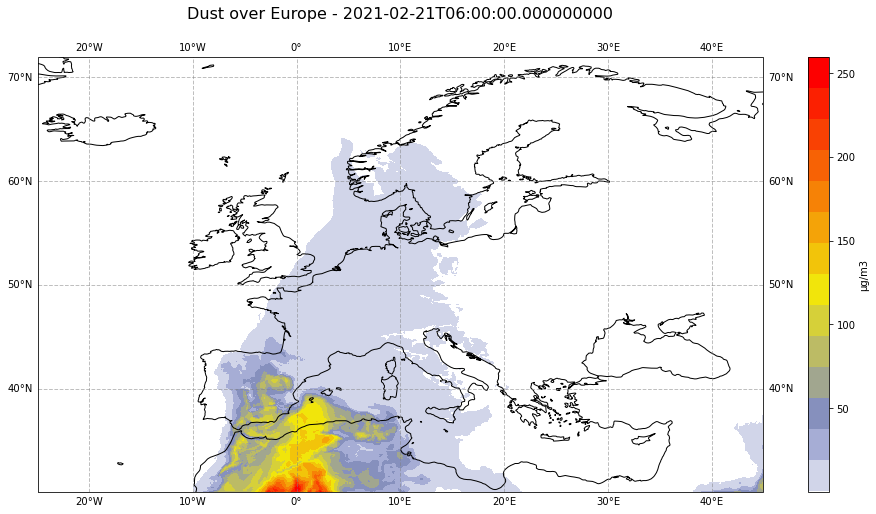

In [21]:
# Index of forecast time step
time_index = 30

# Initiate a matplotlib figure
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Plotting function with pcolormesh
im = plt.pcolormesh(dust['longitude'].values, dust['latitude'].values,
                    dust[time_index,:,:], cmap=camscmp, transform=ccrs.PlateCarree())

# Define geographic extent of the map
ax.set_extent([dust.longitude.min(),dust.longitude.max(),dust.latitude.min(),dust.latitude.max()], crs=ccrs.PlateCarree())

# Add additional features such as coastlines, grid and colorbar
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
cbar = plt.colorbar(im,fraction=0.046, pad=0.05)
cbar.set_label(dust_unit)

# Set the title of the plot
ax.set_title(dust_name + ' over Europe - ' + str(dust.time[time_index].values)+'\n', fontsize=16)

<br>

Above, you see that the forecast predicted dust in the atmosphere on 21 February at 6 UTC, heavily affecting parts of Spain and France.

### <a id='pm10_map'></a> 2.3. Select the variable *pm10_conc* and plot a map of PM10 over Europe in February 2021

Let us now compare the dust forecast with the forecast of `Particulate Matter of particles with a size of 10 microns (PM10)`. Let us load the data array of the variable by adding the name of varible in square brackets. We also apply the function `squeeze()` to drop the dimension `level` which has only one entry.

In [58]:
pm10 = ds_eur_aq['pm10_conc']
pm10 = pm10.squeeze(drop=True)
pm10

<xarray.DataArray 'pm10_conc' (time: 144, latitude: 420, longitude: 700)>
[42336000 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -24.95 -24.85 -24.75 ... 44.75 44.85 44.95
  * latitude   (latitude) float32 71.95 71.85 71.75 71.65 ... 30.25 30.15 30.05
  * time       (time) datetime64[ns] 2021-02-20 ... 2021-02-25T23:00:00
Attributes:
    species:        PM10 Aerosol
    units:          µg/m3
    value:          hourly values
    standard_name:  mass_concentration_of_pm10_ambient_aerosol_in_air

Let us also store the attributes `units` and `species` as variables, which we can use during data visualisation.

In [59]:
pm10_units = pm10.units
pm10_species = pm10.species

<br>

And now we can plot the `PM10` values with the customised color map (`camscmp`). We use the same visualisation code as before, which can be split in five main parts:
* **Initiate a matplotlib figure:** with `plt.figure()` and an axes object
* **Plotting function**: plot the data array with the matplotlib function `pcolormesh()`
* **Define a geographic extent of the map**: use the minimum and maximum latitude and longitude bounds of the data
* **Add additional mapping features**: such as coastlines, grid or a colorbar
* **Set a title of the plot**: you can combine the `species name` and `time` information for the title

Text(0.5, 1.0, 'PM10 Aerosol over Europe - 2021-02-21T06:00:00.000000000\n')

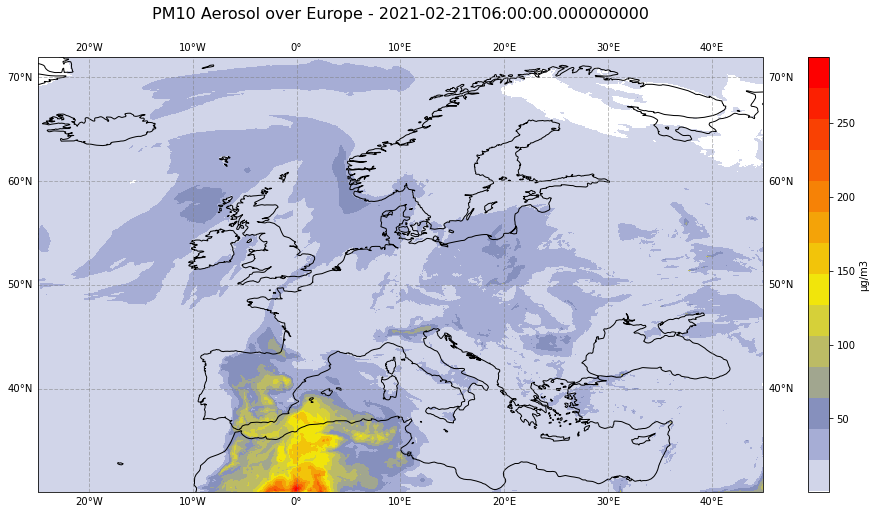

In [60]:
# Index of forecast time step
time_index = 30

# Initiate a matplotlib figure
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Plotting function with pcolormesh
im = plt.pcolormesh(pm10['longitude'].values, pm10['latitude'].values,
                    pm10[time_index,:,:], cmap=camscmp, transform=ccrs.PlateCarree())

# Define geographic extent of the map
ax.set_extent([pm10.longitude.min(),pm10.longitude.max(),pm10.latitude.min(),pm10.latitude.max()], crs=ccrs.PlateCarree())

# Add additional features such as coastlines, grid and colorbar
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
cbar = plt.colorbar(im,fraction=0.046, pad=0.05)
cbar.set_label(pm10_units)

# Set the title of the plot
ax.set_title(pm10_species + ' over Europe - ' + str(pm10.time[time_index].values)+'\n', fontsize=16)

<br>

Above, you see that on 21 February 2021, for many part in central Spain, the PM10 values have by far exceeded the daily limit of 50 micrograms per cubic metre for particulate matter (PM10). This limit is defined in the EU air quality directive (2008/EC/50).

<br>

### <a id='animate_dust_regional'></a>2.4. Animate dust concentration over Europe from 20 to 25 February 2021

In the last step, you can animate the `dust concentration` over Europe in order to see how the trace gas develops over a period of five days, from 20 to 25 February 2021.
You can do animations with matplotlib's function `animation`. Jupyter's function `HTML` can then be used to display HTML and video content.

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [24]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=dust[0,:,:],
                               longitude=dust.longitude, 
                               latitude=dust.latitude,
                               projection=ccrs.PlateCarree(), 
                               color_scale=camscmp, 
                               unit=dust_unit,
                               long_name=dust_name + ' '+ str(dust.time[0].data),
                               vmin=0,
                               vmax=250, 
                               lonmin=dust.longitude.min(), 
                               lonmax=dust.longitude.max(), 
                               latmin=dust.latitude.min(), 
                               latmax=dust.latitude.max(),
                               set_global=False)

frames = 50

def draw(i):
    img = plt.pcolormesh(dust.longitude, 
                         dust.latitude, 
                         dust[i,:,:], 
                         cmap=camscmp, 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=250,
                         shading='auto')
    
    ax.set_title(dust_name + ' '+ str(dust.time[i].data), fontsize=20, pad=20.0)
    return img


def init():
    return fig


def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())
plt.close(fig)

<br>

**Play the animation video as HTML5 video**

In [25]:
HTML(ani.to_html5_video())

<br>

## <a id='global_aq_forecast'></a>3. CAMS global atmospheric composition forecasts

Now, let us discover the CAMS global atmospheric composition forecasts which produces global forecasts for more than 50 chemical species twice a day. The forecasts have a spatial resolution of 0.4 degrees and provide hourly forecasts for up to 5 days (leadtime hour 120h) ahead.

### <a id='cams_forecast_unzip'></a> 3.1 Unzip the downloaded data file

CAMS global atmospheric composition forecasts can be retrieved either in `GRIB` or in a `zipped NetCDF`. In this [data request](./200_atmosphere_data_store_intro.ipynb#cams_global_forecast), we requested the data in a zipped NetCDF and for this reason, we have to unzip the file before we can open it. You can unzip `zip archives` in Python with the Python package `zipfile` and the function `extractall()`. The file extracted is called per default `data.nc`.

In [7]:
import zipfile
with zipfile.ZipFile('./data/cams/20210220_cams_global_forecast_aod.zip', 'r') as zip_ref:
    zip_ref.extractall('./data/cams/')

<br>

### <a id='load_browse_aod'></a> 3.2 Load and browse CAMS global forecast of total Aerosol Optical Depth at 550nm

Once the data has been extracted from the zip archive, you can load the NetCDF file with the Python library [xarray](http://xarray.pydata.org/en/stable/) and the function `open_dataset()`. The function loads a `xarray.Dataset`, which is a collection of one or more data variables that share the same dimensions. You see that the data files has three dimensions, `latitude`, `longitude` and `time` and one variable, `aod550`. 

In [3]:
ds_global_aod = xr.open_dataset('./data/cams/data.nc')
ds_global_aod

<xarray.Dataset>
Dimensions:    (latitude: 451, longitude: 900, time: 31)
Coordinates:
  * longitude  (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2021-02-20 ... 2021-02-23T18:00:00
Data variables:
    aod550     (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-11-03 05:34:39 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

<br>

Let us now extract from the Dataset above the data variable `aod550` as `xarray.DataArray`. You can load a data array from a xarray.Dataset by specifying the name of the variable (`aod550`) in square brackets.

In [4]:
aod550 = ds_global_aod['aod550']
aod550

<xarray.DataArray 'aod550' (time: 31, latitude: 451, longitude: 900)>
[12582900 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.4 0.8 1.2 ... 358.4 358.8 359.2 359.6
  * latitude   (latitude) float32 90.0 89.6 89.2 88.8 ... -89.2 -89.6 -90.0
  * time       (time) datetime64[ns] 2021-02-20 ... 2021-02-23T18:00:00
Attributes:
    units:      ~
    long_name:  Total Aerosol Optical Depth at 550nm

<br>

If we inspect the `time` dimension a bit closer, you see that the data has 31 time steps representing the forecast of `Total Aerosol Optical Depth at 550 nm` from 20 February at 00:00 UTC every three hours up to 23 February 2021 18:00 UTC.

In [5]:
aod550.time

<xarray.DataArray 'time' (time: 31)>
array(['2021-02-20T00:00:00.000000000', '2021-02-20T03:00:00.000000000',
       '2021-02-20T06:00:00.000000000', '2021-02-20T09:00:00.000000000',
       '2021-02-20T12:00:00.000000000', '2021-02-20T15:00:00.000000000',
       '2021-02-20T18:00:00.000000000', '2021-02-20T21:00:00.000000000',
       '2021-02-21T00:00:00.000000000', '2021-02-21T03:00:00.000000000',
       '2021-02-21T06:00:00.000000000', '2021-02-21T09:00:00.000000000',
       '2021-02-21T12:00:00.000000000', '2021-02-21T15:00:00.000000000',
       '2021-02-21T18:00:00.000000000', '2021-02-21T21:00:00.000000000',
       '2021-02-22T00:00:00.000000000', '2021-02-22T03:00:00.000000000',
       '2021-02-22T06:00:00.000000000', '2021-02-22T09:00:00.000000000',
       '2021-02-22T12:00:00.000000000', '2021-02-22T15:00:00.000000000',
       '2021-02-22T18:00:00.000000000', '2021-02-22T21:00:00.000000000',
       '2021-02-23T00:00:00.000000000', '2021-02-23T03:00:00.000000000',
       '2021-02-23T06:00:00.000000000', '2021-02-23T09:00:00.000000000',
       '2021-02-23T12:00:00.000000000', '2021-02-23T15:00:00.000000000',
       '2021-02-23T18:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-02-20 ... 2021-02-23T18:00:00
Attributes:
    long_name:  time

<br>

The loaded data array above also has two attributes, `units` and `long_name`. Let us define two variables for those attributes. The variables can be used later during data visualisation.

In [6]:
aod_unit = aod550.units
aod_long_name = aod550.long_name

<br>

### <a id='visualize_global_aod'></a> 3.3 Visualize a global map of total AOD at 550nm in February 2021


And now we can plot the `Total Aerosol Optical Depth at 550 nm` values with the customised color map (`camscmp`). We use the same visualisation code as before (without setting a geographic extent), which can be split in four main parts:
* **Initiate a matplotlib figure:** with `plt.figure()` and an axes object
* **Plotting function**: plot the data array with the matplotlib function `pcolormesh()`
* **Add additional mapping features**: such as coastlines, grid or a colorbar
* **Set a title of the plot**: you can combine the `species name` and `time` information for the title

Text(0.5, 1.0, 'Total Aerosol Optical Depth at 550nm - 2021-02-21T06:00:00.000000000\n')

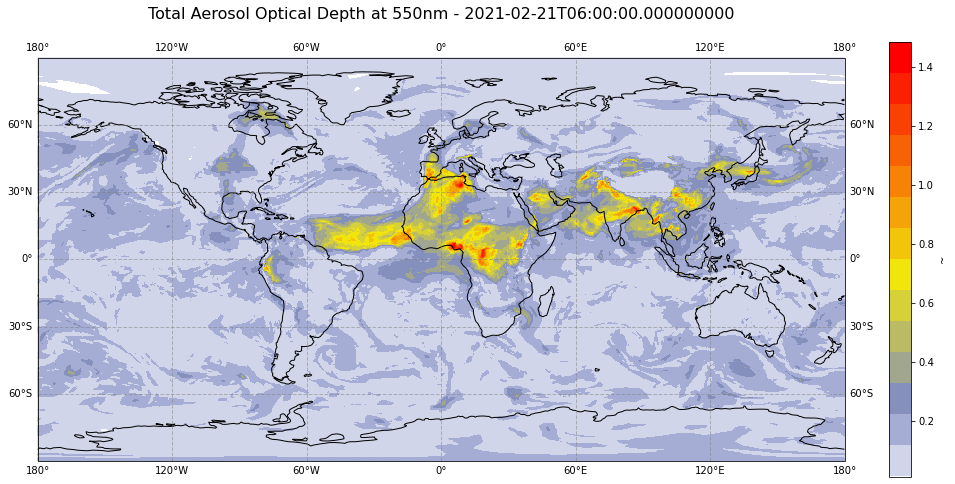

In [7]:
time_index =  10

# Initiate the matplotlib figure
fig = plt.figure(figsize=(16,8))
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())

# Plotting function with pcolormesh
im = plt.pcolormesh(aod550.longitude, aod550.latitude, aod550[time_index,:,:],
                    cmap=camscmp, transform=ccrs.PlateCarree())

# Add additional mapping features
ax.coastlines(color='black')
ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
cbar = plt.colorbar(im,fraction=0.046, pad=0.05)
cbar.set_label(aod_unit)

# Set a title of the plot
ax.set_title(aod_long_name + ' - ' + str(aod550.time[time_index].values)+'\n', fontsize=16)

<br>

<br>

### <a id='animate_dust_global'></a>3.4. Animate global total AOD at 550nm from 20 to 23 February 2021

In the last step, you can animate the `total AOD at 550nm` in order to see how the trace gas develops over a period of four days, from 20 to 23 February 2021.
You can do animations with matplotlib's function `animation`. Jupyter's function `HTML` can then be used to display HTML and video content.

The animation function consists of 4 parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [10]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=aod550[0,:,:],
                               longitude=aod550.longitude, 
                               latitude=aod550.latitude,
                               projection=ccrs.PlateCarree(), 
                               color_scale=camscmp, 
                               unit=aod_unit,
                               long_name=aod_long_name + ' '+ str(aod550.time[0].data),
                               vmin=0,
                               vmax=2, 
                               lonmin=aod550.longitude.min(), 
                               lonmax=aod550.longitude.max(), 
                               latmin=aod550.latitude.min(), 
                               latmax=aod550.latitude.max(),
                               set_global=False)

frames = 31

def draw(i):
    img = plt.pcolormesh(aod550.longitude, 
                         aod550.latitude, 
                         aod550[i,:,:], 
                         cmap=camscmp, 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=2,
                         shading='auto')
    
    ax.set_title(aod_long_name + ' '+ str(aod550.time[i].data), fontsize=20, pad=20.0)
    return img


def init():
    return fig


def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)

HTML(ani.to_html5_video())
plt.close(fig)

<br>

**Play the animation video as HTML5 video**

In [11]:
HTML(ani.to_html5_video())

<hr>

<p><img src='./img/copernicus_logo.png' align='right' alt='Logo EU Copernicus' width='20%'></img></p>
<br><br><br><br><br>
<span style='float:right'><p style=\"text-align:right;\">This project is licensed under <a href="./LICENSE">APACHE License 2.0</a>. | <a href=\"https://github.com/ecmwf-projects/copernicus-training">View on GitHub</a></span>